In [2]:
import horton
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
def build_base(target, mixing, basisset):
    read = horton.io.xyz.load_xyz('../data/benzene.xyz')
    
    target = np.array(target)
    baseline = np.array([7., 7., 7., 7., 7., 7, 0., 0., 0., 0., 0., 0.])
    dZ = target - baseline
    
    horton.log.set_level(0)
    mol = horton.IOData()
    mol.coordinates = read['coordinates']
    mol.numbers = baseline
    mol.pseudo_numbers = baseline + dZ * mixing
    print (mol.pseudo_numbers)
    
    # get grid
    grid = horton.BeckeMolGrid(mol.coordinates, (baseline * 0 + 7).astype(int), baseline * 0 + 7, 'insane', mode='keep', random_rotate=False)
    
    # build basis set
    basisset = basisset
    obasis = horton.get_gobasis(mol.coordinates[:6], baseline[:6].astype(int), basisset)
    for idx, dval in enumerate(dZ):
        if dval == 0:
            continue
        obasis2 = horton.get_gobasis(mol.coordinates[idx:idx+1], target[idx:idx+1].astype(int), basisset)
        obasis = horton.GOBasis.concatenate(obasis, obasis2)
    
    # start calculation
    olp = obasis.compute_overlap()
    kin = obasis.compute_kinetic()
    na = obasis.compute_nuclear_attraction(mol.coordinates, mol.pseudo_numbers)
    er = obasis.compute_electron_repulsion()
    
    orb_alpha = horton.Orbitals(obasis.nbasis)
    orb_beta = horton.Orbitals(obasis.nbasis)
    one = kin + na
    horton.guess_core_hamiltonian(olp, one, orb_alpha, orb_beta)
    
    external = {'nn': horton.compute_nucnuc(mol.coordinates, mol.pseudo_numbers)}
    
    terms = [horton.UTwoIndexTerm(kin, 'kin'), horton.UDirectTerm(er, 'hartree'), horton.UExchangeTerm(er, 'x_hf'), horton.UTwoIndexTerm(na, 'ne')]
    ham = horton.UEffHam(terms, external)
    occ_model = horton.AufbauOccModel(21, 21)
    occ_model.assign(orb_alpha, orb_beta)
    dm_alpha = orb_alpha.to_dm()
    dm_beta = orb_beta.to_dm()
    scf_solver = horton.EDIIS2SCFSolver(1e-5, maxiter=400)
    scf_solver(ham, olp, occ_model, dm_alpha, dm_beta)
    
    fock_alpha = np.zeros(olp.shape)
    fock_beta = np.zeros(olp.shape)
    ham.reset(dm_alpha, dm_beta)
    energy = ham.compute_energy()
    ham.compute_fock(fock_alpha, fock_beta)
    orb_alpha.from_fock_and_dm(fock_alpha, dm_alpha, olp)
    orb_beta.from_fock_and_dm(fock_beta, dm_beta, olp)

    # integration grid
    rho_alpha = obasis.compute_grid_density_dm(dm_alpha, grid.points)
    rho_beta = obasis.compute_grid_density_dm(dm_beta, grid.points)
    rho_full = rho_alpha + rho_beta
    
    return energy, rho_full, external['nn']
    
build_base([6, 6, 7, 5, 6, 6, 1, 1, 1, 1, 1, 1], 1.0, 'def2-tzvp')

[6. 6. 7. 5. 6. 6. 1. 1. 1. 1. 1. 1.]


MemoryError: 

In [3]:
q = [build_base([6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1], _, 'sto-3g') for _ in (0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.)]

[7. 7. 7. 7. 7. 7. 0. 0. 0. 0. 0. 0.]
[6.9 6.9 6.9 6.9 6.9 6.9 0.1 0.1 0.1 0.1 0.1 0.1]
[6.75 6.75 6.75 6.75 6.75 6.75 0.25 0.25 0.25 0.25 0.25 0.25]
[6.5 6.5 6.5 6.5 6.5 6.5 0.5 0.5 0.5 0.5 0.5 0.5]
[6.25 6.25 6.25 6.25 6.25 6.25 0.75 0.75 0.75 0.75 0.75 0.75]
[6.1 6.1 6.1 6.1 6.1 6.1 0.9 0.9 0.9 0.9 0.9 0.9]
[6. 6. 6. 6. 6. 6. 1. 1. 1. 1. 1. 1.]


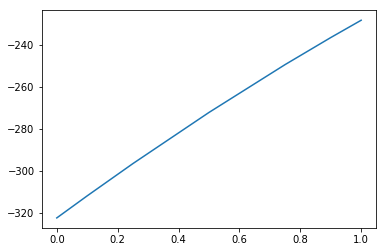

In [4]:
plt.plot((0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.), [_[0] for _ in q])

In [ ]:
def compare(target, basisset):
    read = horton.io.xyz.load_xyz('../data/benzene.xyz')
    
    horton.log.set_level(0)
    mol = horton.IOData()
    mol.coordinates = read['coordinates']
    mol.numbers = target
    mol.pseudo_numbers = target
    
    # build basis set
    basisset = basisset
    obasis = horton.get_gobasis(mol.coordinates, np.array([6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1]), basisset)
    
    # start calculation
    olp = obasis.compute_overlap()
    kin = obasis.compute_kinetic()
    na = obasis.compute_nuclear_attraction(mol.coordinates, np.array(target).astype(float))
    er = obasis.compute_electron_repulsion()
    
    orb_alpha = horton.Orbitals(obasis.nbasis)
    orb_beta = horton.Orbitals(obasis.nbasis)
    one = kin + na
    horton.guess_core_hamiltonian(olp, one, orb_alpha, orb_beta)
    
    external = {'nn': horton.compute_nucnuc(mol.coordinates, mol.pseudo_numbers)}
    
    terms = [horton.UTwoIndexTerm(kin, 'kin'), horton.UDirectTerm(er, 'hartree'), horton.UExchangeTerm(er, 'x_hf'), horton.UTwoIndexTerm(na, 'ne')]
    ham = horton.UEffHam(terms, external)
    occ_model = horton.AufbauOccModel(21, 21)
    occ_model.assign(orb_alpha, orb_beta)
    dm_alpha = orb_alpha.to_dm()
    dm_beta = orb_beta.to_dm()
    scf_solver = horton.EDIIS2SCFSolver(1e-5, maxiter=400)
    scf_solver(ham, olp, occ_model, dm_alpha, dm_beta)
    
    fock_alpha = np.zeros(olp.shape)
    fock_beta = np.zeros(olp.shape)
    ham.reset(dm_alpha, dm_beta)
    energy = ham.compute_energy()
    ham.compute_fock(fock_alpha, fock_beta)
    orb_alpha.from_fock_and_dm(fock_alpha, dm_alpha, olp)
    orb_beta.from_fock_and_dm(fock_beta, dm_beta, olp)

    return energy, 
    
compare([6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1], 'def2-tzvp')#, compare([7, 7, 7, 7, 7, 7, 0, 0, 0, 0, 0, 0], 'sto-3g')

In [7]:
[_[0] for _ in q]

[-322.4708371094975,
 -311.9303349892661,
 -296.559273181618,
 -272.1545726179015,
 -249.33565942824146,
 -236.43318658164128,
 -228.16586008662156]

In [10]:
# generate commands
for basisset in 'sto-3g def2-tzvp'.split():
    for changestr in 'CCCCCC BNCCCC BCNCCC BCCNCC BNCBNC BNBNCC BNBCNC BNCBCN BNCNBC BNCCNB BNNBCC BNCNCB BNNCBC BNNCCB BCNNCB NBNBNB BNBNNB BNNNBB'.split():
        intstr = changestr_to_intstr(changestr)
        for mixing in np.linspace(0, 1, 17):
            print 'python2 ../benzene.py', intstr, mixing, basisset

python2 ../benzene.py 6-6-6-6-6-6-1-1-1-1-1-1 0.0 sto-3g
python2 ../benzene.py 6-6-6-6-6-6-1-1-1-1-1-1 0.0625 sto-3g
python2 ../benzene.py 6-6-6-6-6-6-1-1-1-1-1-1 0.125 sto-3g
python2 ../benzene.py 6-6-6-6-6-6-1-1-1-1-1-1 0.1875 sto-3g
python2 ../benzene.py 6-6-6-6-6-6-1-1-1-1-1-1 0.25 sto-3g
python2 ../benzene.py 6-6-6-6-6-6-1-1-1-1-1-1 0.3125 sto-3g
python2 ../benzene.py 6-6-6-6-6-6-1-1-1-1-1-1 0.375 sto-3g
python2 ../benzene.py 6-6-6-6-6-6-1-1-1-1-1-1 0.4375 sto-3g
python2 ../benzene.py 6-6-6-6-6-6-1-1-1-1-1-1 0.5 sto-3g
python2 ../benzene.py 6-6-6-6-6-6-1-1-1-1-1-1 0.5625 sto-3g
python2 ../benzene.py 6-6-6-6-6-6-1-1-1-1-1-1 0.625 sto-3g
python2 ../benzene.py 6-6-6-6-6-6-1-1-1-1-1-1 0.6875 sto-3g
python2 ../benzene.py 6-6-6-6-6-6-1-1-1-1-1-1 0.75 sto-3g
python2 ../benzene.py 6-6-6-6-6-6-1-1-1-1-1-1 0.8125 sto-3g
python2 ../benzene.py 6-6-6-6-6-6-1-1-1-1-1-1 0.875 sto-3g
python2 ../benzene.py 6-6-6-6-6-6-1-1-1-1-1-1 0.9375 sto-3g
python2 ../benzene.py 6-6-6-6-6-6-1-1-1-1-1-1 1.0 sto-

In [5]:
def changestr_to_intstr(changestr):
    return '-'.join(map(str, [{'C': 6, 'N': 7, 'B': 5}[_] for _ in changestr] + [1]*6))
changestr_to_intstr('BCNCCC')

'5-6-7-6-6-6-1-1-1-1-1-1'